In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [3]:
d=0.125
q=8.1
fi_1=1
p_0=15e6
p_ign=5e6
l_p=5.515
n_s=1
S=np.pi*d**2*n_s/4

p_0a=1e5
c_0a=340
k_a=1.4

In [4]:

CFL=0.9
N_cells=200

w_q=1.074
Delta=759
w=w_q*q
W_0=w/Delta

l_0=W_0/S


In [5]:
I_e=1.18*1e6
f=1.259*1e6
delta=1650
b=1.12*1e-3
z_e=1
kappa_1=1
lamda_1=0
kappa_2=0
lamda_2=0
k_g=1.257
k_I=2.2*1e-3
k_f=0.3e-3
T_c=3300

psi_s=kappa_1*(1+lamda_1)
forma='1'

R_g=f/T_c

k_ign=1.22
b_ign=0.6*1e-3
f_ign=260000
T_ign=2427
R_ign=f_ign/T_ign
delta_ign=1700

w_ign=p_ign/f_ign*(W_0-w/delta)*(1/(1+b_ign*p_ign/f_ign))



In [6]:
p=np.zeros(N_cells)
rho=np.zeros(N_cells)
v=np.zeros(N_cells+1)
eps=np.zeros(N_cells)
z=np.zeros(N_cells)
x=np.linspace(0, l_0,N_cells+1)
k=np.zeros(N_cells)

C_ign=w_ign/(w_ign+w)
C_=w/(w_ign+w)

p[:]=p_ign

rho[:]=(w+w_ign)/W_0
v[:]=0
eps[:]=p_ign/(k_ign-1)*(1/rho[0]-C_/delta-C_ign*b_ign)+C_*f/(k_g-1)
z[:]=0
k[:]=k_ign

q_=(w+w_ign)/N_cells

def Psi(z):
    if forma == '1':
        return kappa_1*z*(1+lamda_1*z)
    if forma == '7':
        if z < 1:
            return kappa_1*z*(1+lamda_1*z)
        if z >=1:
            return psi_s+kappa_2*(z-1)*(1+lamda_2*(z-1))
def p_a(v_p):
    A=1+(k_a*(k_a+1))/4*(v_p/c_0a)**2
    B=k_a*v_p/c_0a*np.sqrt(1+((k_a+1)/4*v_p/c_0a)**2)
    return p_0a*(A+B)

def get_tau(x, v, p, rho, k ,z):
    c=np.zeros(len(z))
    for i in range(len(z)):
        c[i]=1/rho[i]*np.sqrt(k[i]*p[i]/(1/rho[i]-C_*(1-Psi(z[i]))/delta-Psi(z[i])*b*C_-C_ign*b_ign))
    tau=CFL*min((x[1:]-x[:-1])/(np.abs(v[1:])+c))
    return tau

def H(z, z_e):
    if z > z_e:
        return 0
    else:
        return 1

def next_layer(v, tau, p, rho,x, eps, z, q_):
    v_next=np.zeros(N_cells+1)
    p_next=np.zeros(N_cells)
    rho_next=np.zeros(N_cells)
    z_next=np.zeros(N_cells)
    eps_next=np.zeros(N_cells)
    delta_x_next=np.zeros(N_cells)
    x_next=np.zeros(N_cells+1)
    z_next=np.zeros(N_cells)
    k_next=np.zeros(N_cells)
    
    v_next[0]=0
    x_next[0]=0
    
    for i in range(N_cells-1):
        v_next[i+1]=v[i+1]-tau*S*(p[i+1]-p[i])/q_ 
        x_next[i+1]=x[i+1]+tau*v_next[i+1]
    
    if p[-1] < p_0+p_0a and x[-1] <= l_0:
        x_next[-1]=l_0
        v_next[-1]=0
    else:
        v_next[-1]=v[-1]+tau*S*(p[-1]-p_a(v[-1]))/(0.5*q_+fi_1*q)
        x_next[-1]=x[-1]+tau*v_next[-1]
        
    delta_x_next[:]=x_next[1:]-x_next[:-1]
    rho_next[:]=q_/delta_x_next[:]/S
        
    
    for i in range(N_cells):
        eps_next[i]=eps[i]-tau*p[i]*S*(v_next[i+1]-v_next[i])/q_
        z_next[i]=z[i]+tau*p[i]/I_e*H(z[i], z_e)
        psi=Psi(z_next[i])
        k_next[i]=1+(C_ign*R_ign+C_*R_g*psi)/((C_ign*R_ign/(k_ign-1))+(C_*R_g*psi/(k_g-1)))
        p_next[i]=(k_next[i]-1)*(eps_next[i]-C_*(1-psi)*f/(k_g-1))/(
            1/rho_next[i]-C_*(1-psi)/delta-psi*b*C_-C_ign*b_ign
        )
        
    return delta_x_next, v_next, rho_next, p_next, eps_next, z_next, k_next

layers=np.array([])
init={'t': 0,
      'x': x,
      'p': p,
      'rho': rho,
      'v': v,
      'eps': eps,
      'z': z,
      'k': k
}
layers=np.append(layers, init)

n_test=300
#for j_i in range(n_test):
while(layers[-1]['x'][-1] < l_p+l_0):
    tau=get_tau(
        layers[-1]['x'],
        layers[-1]['v'],
        layers[-1]['p'],
        layers[-1]['rho'],
        layers[-1]['k'],
        layers[-1]['z']
    )
    delta_x_next, v_next, rho_next, p_next, eps_next, z_next, k_next = next_layer(
        layers[-1]['v'],
        tau,
        layers[-1]['p'],
        layers[-1]['rho'],
        layers[-1]['x'],
        layers[-1]['eps'],
        layers[-1]['z'],
        q_,
    )
    x_next=np.zeros(N_cells+1)
    x_next[0]=0
    for ind in range(N_cells):
        x_next[ind+1]=sum(delta_x_next[:ind+1])
    next_={'t': layers[-1]['t']+tau,
      'x': x_next,
      'p': p_next,
      'rho': rho_next,
      'v': v_next,
      'eps': eps_next,
      'z': z_next,
       't': layers[-1]['t']+tau,
        'k': k_next
        }
    layers=np.append(layers, next_)

In [7]:
t=np.zeros(len(layers))
v=np.zeros(len(layers))
p=np.zeros(len(layers))
x=np.zeros(len(layers))
p_snar=np.zeros(len(layers))
p_kn=np.zeros(len(layers))
z_snar=np.zeros(len(layers))
z_kn=np.zeros(len(layers))

for i in range(len(layers)):
    t[i]=layers[i]['t']
    v[i]=layers[i]['v'][-1]
    delta_x=layers[i]['x'][1:]-layers[i]['x'][:-1]
    p[i]=sum(layers[i]['p']*delta_x)/layers[i]['x'][-1]
    x[i]=layers[i]['x'][-1]
    p_snar[i]=layers[i]['p'][-1]
    p_kn[i]=layers[i]['p'][0]
    z_kn[i]=layers[i]['z'][0]
    z_snar[i]=layers[i]['z'][-1]

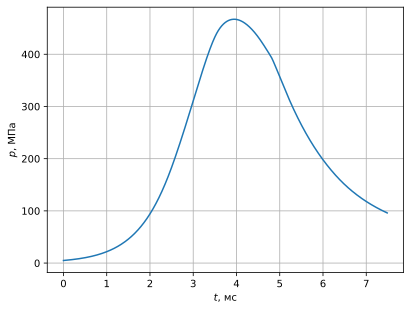

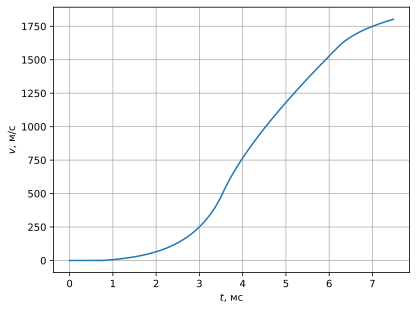

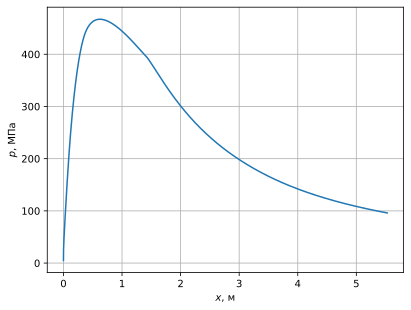

In [15]:
%config InlineBackend.figure_format = 'svg'

plt.plot(t*1e3, p/1e6)
plt.xlabel("$t$, мс")
plt.ylabel("$p$, МПа")
plt.grid()
plt.show()

plt.plot(t*1e3, v)
plt.xlabel("$t$, мс")
plt.ylabel("$v$, м/с")
plt.grid()
plt.show()

plt.plot(x - x[0], p/1e6)
plt.xlabel("$x$, м")
plt.ylabel("$p$, МПа")
plt.grid()
plt.show()